# Food Ingredients Recognition Segmentation and classification

The project is a segmentation and classification problem, where each food item on a plate is segmented and classified by our deep learning model. The dataset consists of about 6000 labeled training images and 40 food classes (on aicrowd.com). Note: images can contain multiple classes and multiple instances of the same class. 


## Importing Libraries

We import keras, tensorflow_examples, and tensorflow for the deep learning process, google.colab to access files, matplotlib to plot files, numpy for computation and os for checking for files. Additionally, since the annotations are in the coco format, we install coco library to read and access the files. 

In [ ]:
#installing coco library
!pip install git+https://github.com/AIcrowd/coco.git#subdirectory=PythonAPI
#https://github.com/AIcrowd/food-recognition-challenge-starter-kit/blob/master/Dataset%20Utils.ipynb
#https://github.com/AIcrowd/food-recognition-challenge-starter-kit/blob/master/Local%20Evaluation.ipynb

  Cloning https://github.com/AIcrowd/coco.git to /tmp/pip-req-build-m4c4_4le
  Running command git clone -q https://github.com/AIcrowd/coco.git /tmp/pip-req-build-m4c4_4le
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275100 sha256=eb3d20cdc5c684919136fd09555772464e3da16ae9f00a842309f813d2c7dbd3
  Stored in directory: /tmp/pip-ephem-wheel-cache-mv24up9m/wheels/ab/90/04/967e938726d585d7f0cdf0522611965b7e138f6cd9a6937b35
Successfully built pycocotools


In [ ]:
#installing library for pix2pix
!pip install git+https://github.com/tensorflow/examples

  Cloning https://github.com/tensorflow/examples to /tmp/pip-req-build-qk08kjtx
  Running command git clone -q https://github.com/tensorflow/examples /tmp/pip-req-build-qk08kjtx
  Created wheel for tensorflow-examples: filename=tensorflow_examples-2f1e9cb83f49f4678bbfcf9abbc677551ed557c4_-cp36-none-any.whl size=74919 sha256=c1425fc68c7fbbbb5c8423b61e7a62e6fa7c30c9d41b8ee2a9c243aa3a47b0a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-2jiosu19/wheels/e7/73/87/5fb46323c874b9ed2c75b19999dcf82a37030e6c17501164b6
Successfully built tensorflow-examples


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [ ]:
#model fitting
from keras import backend as K
from tensorflow_examples.models.pix2pix import pix2pix

#accessing data on drive
from google.colab import drive

#plotting
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#computation
import numpy as np

#reading and accessing coco formatted data
from pycocotools.coco import COCO
from pycocotools import mask as cocomask

#file checking
import os

#mounting drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


## Loading in Data

Here we use the coco libaries to read the jsons and access the files.

In [ ]:
#Loading the coco annotations
ADLFolderLocation = '/content/drive/My Drive/ADLFinalProject/'

#note validation and training set are nearly the same - will combine and split later
coco = COCO(ADLFolderLocation + 'annotations_train.json')
coco_val = COCO(ADLFolderLocation + 'annotations_val.json')

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


## Exploring the data

To explore the data we plot training images and their associated segmentations.

In [ ]:
#given an image_id, plot the image and mask
def plot_image(image_id):

  #reading image
  img = mpimg.imread(ADLFolderLocation  + 'train_images/' + 
                        (6 - len(str(image_id))) * str(0) +
                             str(image_id) + '.jpg')
  
  #displayin image
  imgplot = plt.imshow(img)

  #loading image id
  anns_ids = coco.getAnnIds(imgIds = image_id)
  anns = coco.loadAnns(anns_ids)
  
  #iterating through annotations
  for i in range(len(anns)):

    #picking a different color for each annotation
    col = ['b', 'g', 'r', 'c', 'm', 'y', 'k'][i]

    ann = anns[i]

    #plotting the segmentation
    for seg in ann['segmentation']:
        plt.fill(seg[0::2],
               seg[1::2], col, alpha = 0.4)
        
  #showing the results
  plt.show()

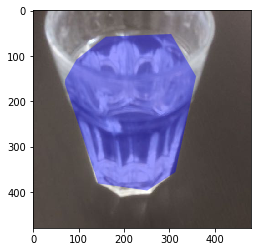

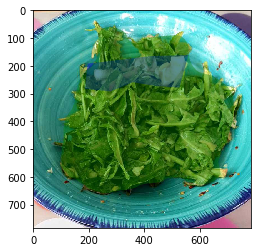

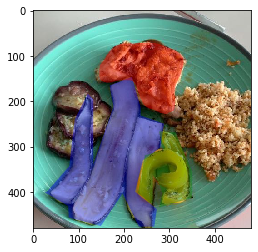

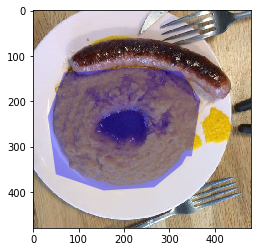

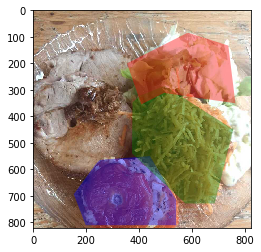

In [ ]:
#plotting a few random images
np.random.seed(100)
rand_image_nums = np.random.randint(0, len(coco.getImgIds()), 5)

for rand_num in rand_image_nums:

  plot_image(coco.getImgIds()[rand_num])

## Loading and Cleaning Data
Before the model fitting process, we use the coco library and tensorflow image reading functions to read in the images, read in their associated segmentations and save them to a tensor.

First, we get the categorical ids and put them in a list ordered by commonality of category. The class will be the index of the categorical id in this list. The order places the most common food class at 41, while the least common at 1. The 0 class which represents no food remains the most common class overall.

In [ ]:
#getting categories
cat_ids_raw = coco.getCatIds()

#creating blank list to add categories to
cat_ids = []

#iterating through and adding number of images per category and category to list
for cat in cat_ids_raw:
  cat_ids.append([len(coco.getImgIds(catIds = cat)), cat])


#sorting by number of images per category
cat_ids.sort()

#extracting categorical number for each id
cat_ids = [cat_num[1] for cat_num in cat_ids]

Next we load all the "training" and "validation" images. Since they appear to be arbitrarily assigned, we load them both and randomly reassign training / validation status.

In [ ]:
#checking if files for x and y already exist
train_data_not_saved = not (os.path.exists(ADLFolderLocation + "x_3.npy") and os.path.exists(ADLFolderLocation + "y_3.npy"))
val_data_not_saved = not (os.path.exists(ADLFolderLocation + "x_val.npy") and os.path.exists(ADLFolderLocation + "y_val.npy"))


#size that images are resized to
image_size = 256

#determining number of classes / images
num_classes = len(cat_ids) + 1
num_images = len(coco.getImgIds())
num_images_val = len(coco_val.getImgIds())

#only running if the data needs to be saved
if train_data_not_saved:


  #creating blank X and Y length of number of observations
  X = np.zeros((num_images, image_size, image_size, 3))
  Y = np.zeros((num_images, image_size, image_size, 1))

  #iterating through "train" images
  for i in range(num_images):

    #printing how far in iteration
    print(str(i+1) + ' / ' + str(num_images))

    #image is current image
    image = coco.getImgIds()[i]

    #getting annotations
    anns_ids = coco.getAnnIds(imgIds= image)
    anns = coco.loadAnns(anns_ids)

    #creating matrix of zeros to store annotations. Zero represents no food class
    anns_img = np.zeros((coco.imgs[image]['height'] ,
                     coco.imgs[image]['width'],
                     1))
    

    #iterating through
    for ann in anns:

        #determining class by index in the cat_ids list
        ann_class = cat_ids.index(ann['category_id']) + 1

        #filling zeros matrix with appropriate class
        #when there is multiclass overlap more common class wins since we sorted above
        anns_img[:,:,0] = np.maximum(anns_img[:,:,0],
                                           coco.annToMask(ann) * ann_class)



    #resizing image
    anns_img = tf.image.resize(anns_img, (image_size, image_size))
    
    #saving image to y
    Y[i] = anns_img

    #image path
    image_path = (ADLFolderLocation + 'train_images/' + 
                        (6 - len(str(image))) * str(0) +
                             str(image) + '.jpg')


    #loading in images and resizing
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (image_size, image_size))


    #saving observation and normalizing
    X[i] = img
    X[i] = X[i]/255.0

  #saving results
  np.save(arr = X, file = ADLFolderLocation + 'x_3')

  np.save(arr = Y, file = ADLFolderLocation + 'y_3')    


#only running if the data needs to be saved
if val_data_not_saved:

  #creating blank X and Y length of number of observations
  X_val = np.zeros((num_images_val, image_size, image_size, 3))
  Y_val = np.zeros((num_images_val, image_size, image_size, 1))

  #same process for validation set
  for i in range(num_images_val):

    #printing how far in iteration
    print(str(i+1) + ' / ' + str(num_images_val))

    #image is current image
    image = coco_val.getImgIds()[i]

    #getting annotations
    anns_ids = coco_val.getAnnIds(imgIds= image)
    anns = coco_val.loadAnns(anns_ids)

    #creating matrix of zeros to store annotations. Zero represents no food class
    anns_img = np.zeros((coco_val.imgs[image]['height'] ,
                      coco_val.imgs[image]['width'],
                      1))
    
    #iterating through
    for ann in anns:

        
        #determining class by index in the cat_ids list
        ann_class = cat_ids.index(ann['category_id']) + 1


        #filling zeros matrix with appropriate class
        #when there is multiclass overlap more common class wins since we sorted above
        anns_img[:,:,0] = np.maximum(anns_img[:,:,0],
                                           coco_val.annToMask(ann) * ann_class)

      

    #resizing image
    anns_img = tf.image.resize(anns_img, (image_size, image_size))

    #saving image to y
    Y_val[i] = anns_img

    #image path
    image_path = (ADLFolderLocation + 'val_images/' + 
                        (6 - len(str(image))) * str(0) +
                             str(image) + '.jpg')


    #loading in images and resizing
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (image_size, image_size))

    #saving observation and normalizing
    X_val[i] = img
    X_val[i] = X_val[i]/255.0

  #saving results
  np.save(arr = X_val, file = ADLFolderLocation + 'x_val')

  np.save(arr = Y_val, file = ADLFolderLocation + 'y_val') 

## Building Model Architecture

Here we are training a UNet model. We used this [tensorflow tutorial](https://www.tensorflow.org/tutorials/images/segmentation) to create our model architecture.

In [ ]:
#using mobilenetv2 model to 
mobileNet_model = tf.keras.applications.MobileNetV2(input_shape=[image_size, image_size, 3], 
                                                    include_top=False)

# Use the activations of these from mobileNetV2 model
layer_names = [
    'block_1_expand_relu',  
    'block_3_expand_relu',  
    'block_6_expand_relu', 
    'block_13_expand_relu', 
    'block_16_project'
]
layers = [mobileNet_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=mobileNet_model.input, outputs=layers)

down_stack.trainable = False

/tensorflow-2.0.0/python3.6/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [ ]:
layers

[<tf.Tensor 'block_1_expand_relu_3/Identity:0' shape=(None, 128, 128, 96) dtype=float32>,
 <tf.Tensor 'block_3_expand_relu_3/Identity:0' shape=(None, 64, 64, 144) dtype=float32>,
 <tf.Tensor 'block_6_expand_relu_3/Identity:0' shape=(None, 32, 32, 192) dtype=float32>,
 <tf.Tensor 'block_13_expand_relu_3/Identity:0' shape=(None, 16, 16, 576) dtype=float32>,
 <tf.Tensor 'block_16_project_3/Identity:0' shape=(None, 8, 8, 320) dtype=float32>]

In [ ]:
inceptRes = tf.keras.applications.ResNet152V2(input_shape=[image_size, image_size, 3], 
                                            weights='imagenet', include_top=False)
inceptRes.summary()

234553344/234545216 [==============================] - 15s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
____________________

In [ ]:
#using mobilenetv2 model to 
dense_net_model = tf.keras.applications.DenseNet201(input_shape=[image_size, image_size, 3], 
                                                    include_top=False)

# Use the activations of these from mobileNetV2 model
layer_names = [
    'conv1/relu',  
    'pool2_relu',  
    'pool3_relu', 
    'pool4_relu', 
    'conv5_block32_0_relu'
]
layers = [dense_net_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=mobileNet_model.input, outputs=layers)

down_stack.trainable = False

74842112/74836368 [==============================] - 6s 0us/step


NameError: ignored

In [ ]:
#using mobilenetv2 model to 
resnet = tf.keras.applications.ResNet152V2(input_shape=[image_size, image_size, 3], 
                                                    include_top=False)

# Use the activations of these from mobileNetV2 model
layer_names = [
    'conv1_conv',  
    'conv2_block3_1_relu',  
    'conv3_block8_1_relu', 
    'conv4_block36_1_relu', 
    'post_relu'
]
layers = [resnet.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=resnet.input, outputs=layers)

down_stack.trainable = False

In [ ]:
#dense_model.summary

In [ ]:
layers

In [ ]:
#usied for
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

Here, we create a function for that returns a unet model.

In [ ]:
#creates a UNet model for the given number of output channels
def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')


  #inputs of model
  inputs = tf.keras.layers.Input(shape=[image_size, image_size, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Next, we initiate a model and display the architecture.

In [ ]:
#creating 41 class model
model = unet_model(41)

In [ ]:
#showing architecture
tf.keras.utils.plot_model(model, show_shapes=True)

## Creating Weights for Model and Custom Loss Function
Since there are a considerably more pixels of class 0 (no food class) than all the other classes combined, we must reweight all the classes to prevent the model from simply predicting every pixel as class 0. Since there is no way in base tensorflow or keras to weight multiclass models that have more than 3 classes, we must create a custom loss function.

First we load the mask information and initiate dictionaries to store class counts.

In [ ]:
#loading y if it does not exist
if not ('Y' in locals()):
  Y = np.load(file = ADLFolderLocation + 'y_3.npy')    

#creating dictionaries to store number of classes and class weights
count_values={}
class_weights = {}

#initializing the counts at 0
j=0
for j in range(num_classes):
  count_values[j] = 0 

Next, we count the number of pixels for each class.

In [ ]:
#setting i to 0 to start
i=0

#saving variable for total number of pixels
total_size = 0

#iterating through Y observations
for i in range(len(Y)):

  #iterating through 41 classes
  j = 0
  for j in range(num_classes):
    #counting number of pixels from given class
    count_values[j] = count_values[j] + sum(sum(Y[i] == j))[0]
  
  #increasing total size
  total_size = total_size  + (256*256)


#testing to make sure weights
print('The percent of Y that is 0 class is: '+str(count_values[0]/total_size))
print('The percent of Y that is 1 class is: '+str(count_values[1]/total_size))
print('The percent of Y that is 40 class is: '+str(count_values[40]/total_size))

The percent of Y that is 0 class is: 0.7252489507897035
The percent of Y that is 1 class is: 0.0019052930303905546
The percent of Y that is 40 class is: 0.03131951898793254


In [ ]:
#iterating through each class
j=0
for j in range(num_classes):
  #class_weights[j] = (1/count_values[j]) * 100000

  if j == 0:
    class_weights[j] = 0.1
  else:
    class_weights[j] = 0.5

Finally, we create a custom loss function.

In [ ]:
#This is an attempt at a custom loss function from:
#https://stackoverflow.com/questions/51793737/custom-loss-function-for-u-net-in-keras-using-class-weights-class-weight-not

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        #axis = -1 #if channels last 
        axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(K.cast(i,'int64'), K.cast(classSelectors,'int64')) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        #x1 = K.cast(x_input, dtype='int32')
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [ ]:
weights = class_weights.values()
weights

dict_values([0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

## Training Model

Here, we compile and fit the model.

In [ ]:
#compiling with custom weight function
model.compile(optimizer='adam', loss=weightedLoss(tf.keras.losses.sparse_categorical_crossentropy,weights),
              #sample_weight_mode='temporal' , loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#This is currently not used

#class_weights_matrix = np.zeros((256, 256, 41))
#i=0
#for i in range(num_classes):
#  class_weights_matrix[:,:, i] += class_weights[i]



In [ ]:
#loading X and Y if needed
if not ('Y' in locals()):
  Y = np.load(file = ADLFolderLocation + 'y_3.npy')    

if not ('X' in locals()):
  X =  np.load(file = ADLFolderLocation + 'x_3.npy')
#try with class weights

#https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
#https://stackoverflow.com/questions/51793737/custom-loss-function-for-u-net-in-keras-using-class-weights-class-weight-not

#fitting vlaues
model_history = model.fit(x = X,
                          validation_split = 0.25,
                          y = Y, epochs=10)

Train on 4158 samples, validate on 1387 samples
Epoch 1/10
4158/4158 [==============================] - 61s 15ms/sample - loss: 0.0396 - accuracy: 0.7745 - val_loss: 0.1451 - val_accuracy: 0.7822
Epoch 2/10
4158/4158 [==============================] - 61s 15ms/sample - loss: 0.0354 - accuracy: 0.7747 - val_loss: 0.1483 - val_accuracy: 0.8172
Epoch 3/10
4158/4158 [==============================] - 61s 15ms/sample - loss: 0.0325 - accuracy: 0.7730 - val_loss: 0.1539 - val_accuracy: 0.7605
Epoch 4/10
4158/4158 [==============================] - 61s 15ms/sample - loss: 0.0289 - accuracy: 0.7726 - val_loss: 0.1519 - val_accuracy: 0.8279
Epoch 5/10
4158/4158 [==============================] - 61s 15ms/sample - loss: 0.0265 - accuracy: 0.7715 - val_loss: 0.1567 - val_accuracy: 0.8148
Epoch 6/10
4158/4158 [==============================] - 61s 15ms/sample - loss: 0.0241 - accuracy: 0.7718 - val_loss: 0.1621 - val_accuracy: 0.8288
Epoch 7/10
4158/4158 [==============================] - 61s 15ms

Plotting model history:

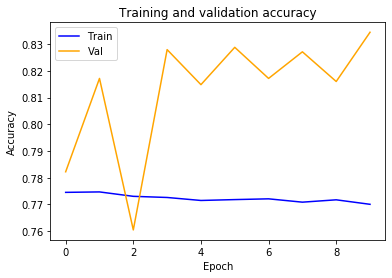

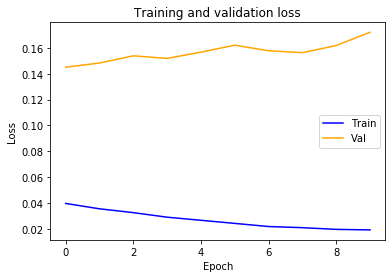

In [ ]:
# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(model_history)

## Making Predictions

In [ ]:

def plot_prediction(i, category = None, show = False, return_val = False, show_all_classes = False):
  


  plt.imshow(X[i])
  if show:
    predictions = model.predict(X[i].reshape(1, image_size, image_size, 3))

    predictions = predictions[0]

    plt.imshow(predictions.argmax(axis = 2) == category, alpha = 0.5)

    if show_all_classes == True:
      for j in range(1,41):
        print(coco.cats[cat_ids[j-1]]['name']+ ' : ')
        plt.imshow(X[i])
        plt.imshow(predictions[:,:,j],alpha=0.7)
        plt.show()

    if return_val:

      return predictions

In [ ]:
#coco.cats

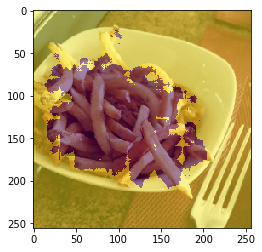

In [ ]:
test_plot = plot_prediction(i = 34, show = True, category = 0, return_val = True)

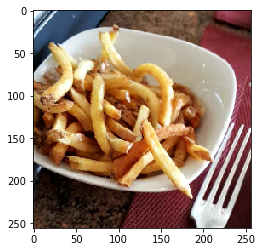

In [ ]:
plot_prediction(i = 34, show = False, category = 1085, return_val = True)

leaf-spinach : 


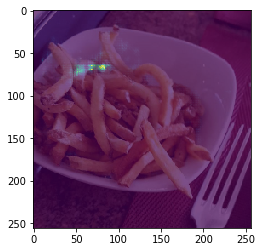

pasta-spaghetti : 


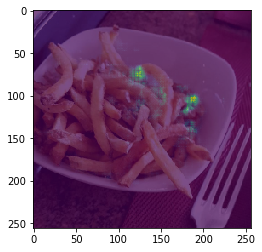

french-beans : 


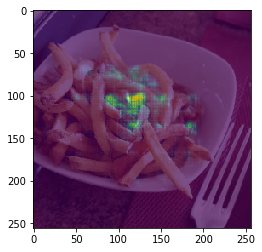

mayonnaise : 


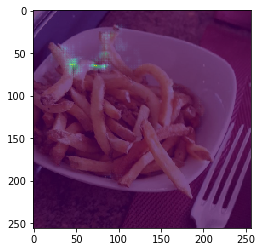

water-mineral : 


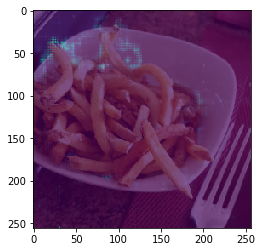

broccoli : 


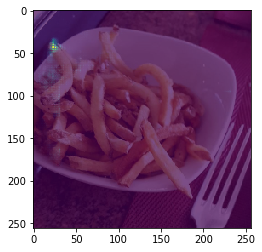

bread-whole-wheat : 


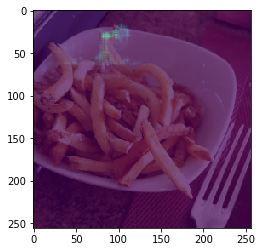

dark-chocolate : 


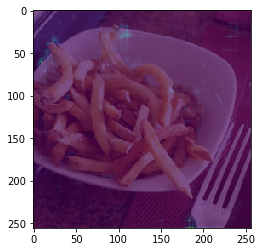

strawberries : 


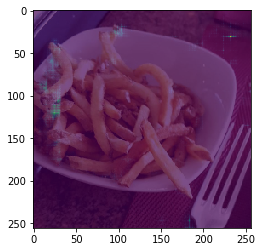

pizza-margherita-baked : 


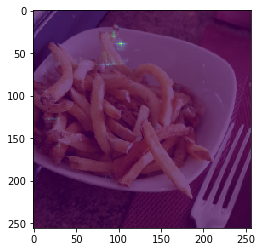

wine-white : 


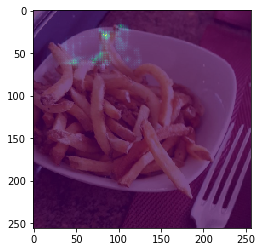

sweet-pepper : 


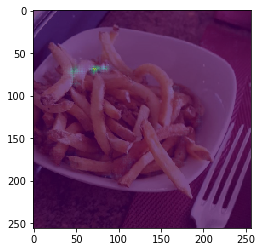

tomato-sauce : 


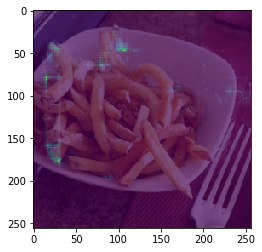

white-coffee-with-caffeine : 


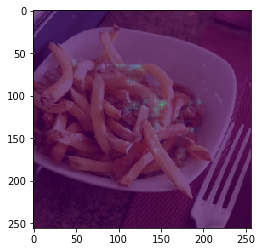

chips-french-fries : 


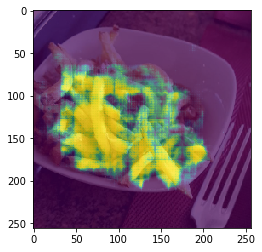

zucchini : 


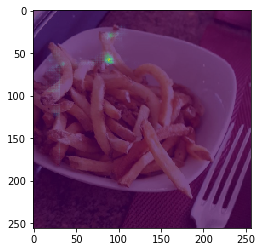

hard-cheese : 


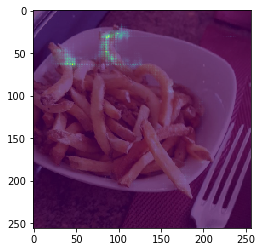

avocado : 


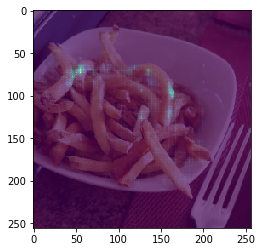

cucumber : 


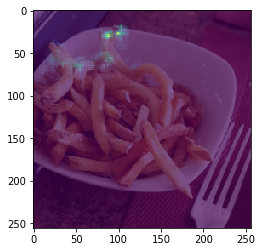

chicken : 


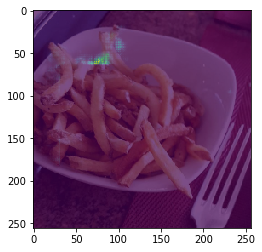

mixed-salad-chopped-without-sauce : 


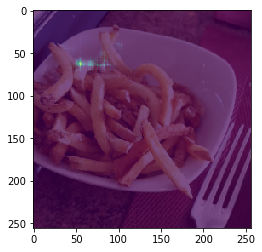

cheese : 


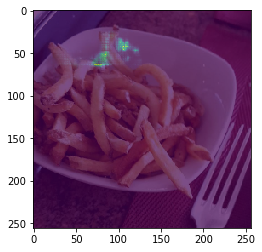

apple : 


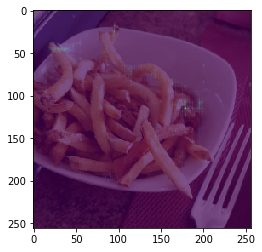

tea : 


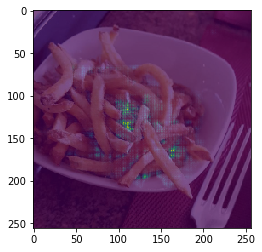

potatoes-steamed : 


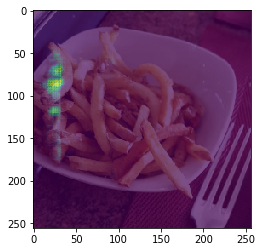

espresso-with-caffeine : 


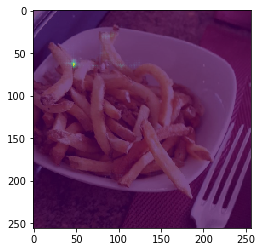

banana : 


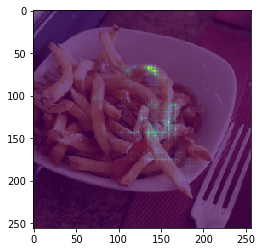

jam : 


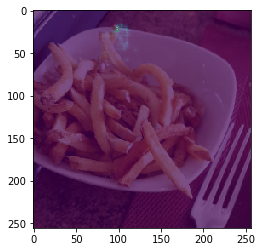

wine-red : 


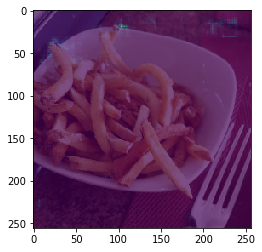

egg : 


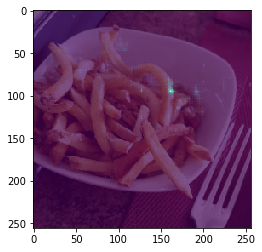

rice : 


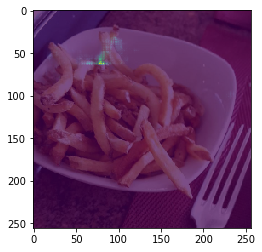

mixed-vegetables : 


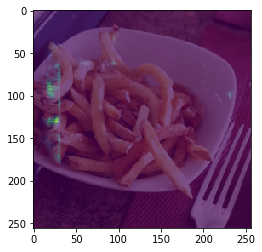

coffee-with-caffeine : 


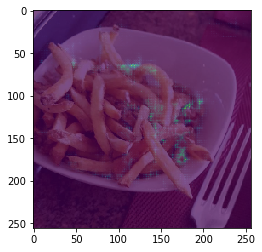

carrot : 


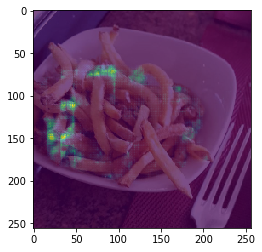

bread-wholemeal : 


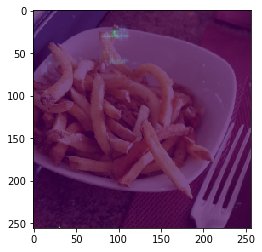

butter : 


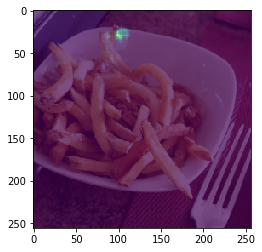

tomato : 


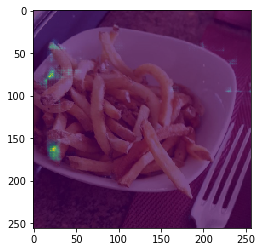

bread-white : 


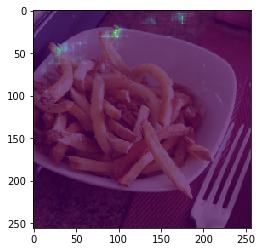

salad-leaf-salad-green : 


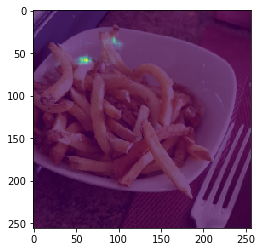

water : 


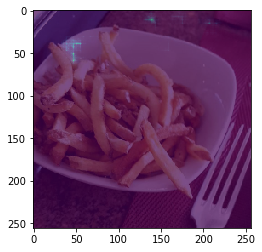

In [ ]:
plot_prediction(i = 34, show = True, category = 1085, return_val = False,show_all_classes = True)


In [ ]:

cat_ids = coco.getCatIds()

cat_ids.sort()

In [ ]:
cat_ids.index(1040)

5

In [ ]:
cat_ids.index(2512)

31

In [ ]:
cat_ids[25]

2022

In [ ]:
#coco.cats

In [ ]:
coco.cats[1154]['name']

'banana'

In [ ]:
import pandas as pd
pd.DataFrame(pred.argmax(axis = 2)).to_csv('test.csv')

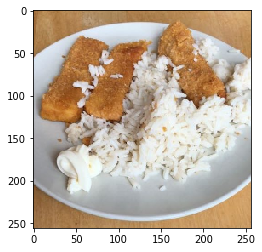

In [ ]:
plot_prediction(i = 30, show = False, category = 0)

leaf-spinach : 


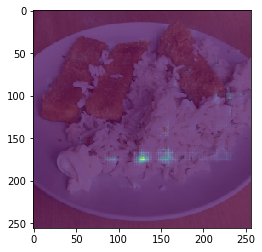

pasta-spaghetti : 


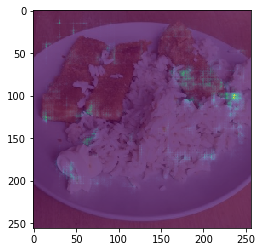

french-beans : 


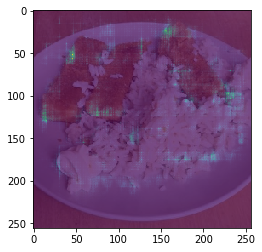

mayonnaise : 


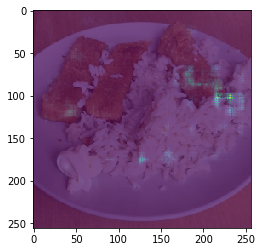

water-mineral : 


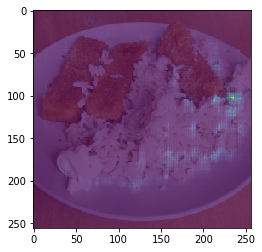

broccoli : 


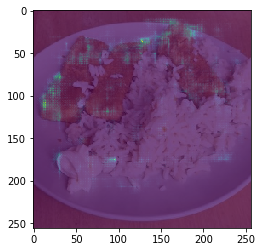

bread-whole-wheat : 


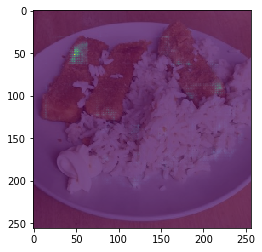

dark-chocolate : 


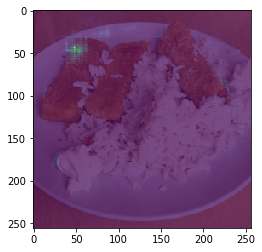

strawberries : 


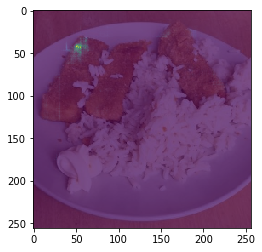

pizza-margherita-baked : 


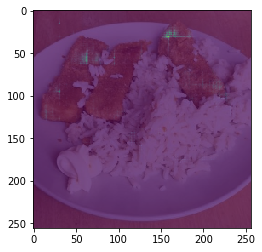

wine-white : 


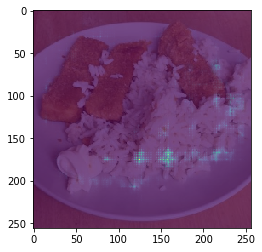

sweet-pepper : 


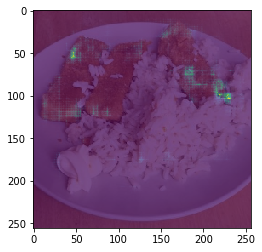

tomato-sauce : 


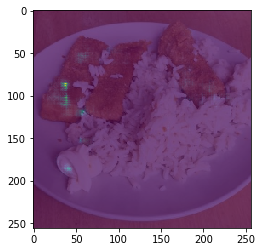

white-coffee-with-caffeine : 


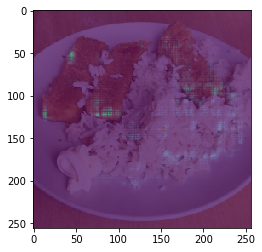

chips-french-fries : 


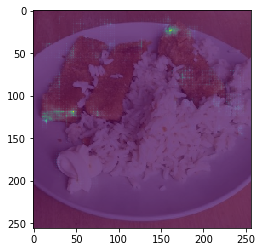

zucchini : 


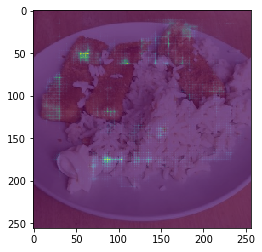

hard-cheese : 


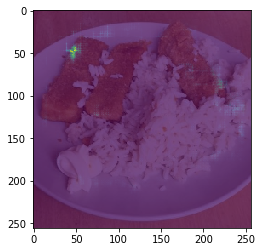

avocado : 


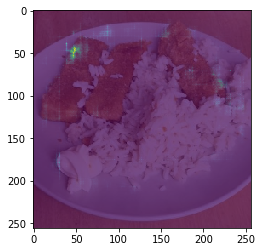

cucumber : 


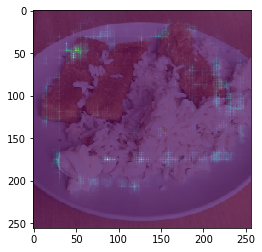

chicken : 


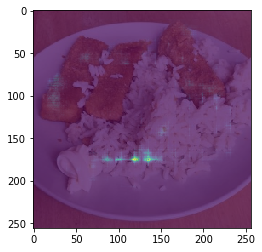

mixed-salad-chopped-without-sauce : 


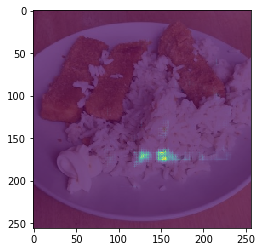

cheese : 


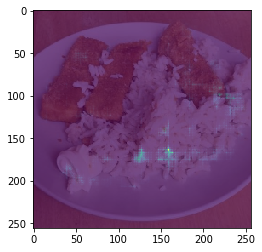

apple : 


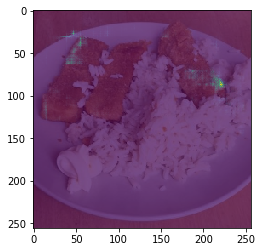

tea : 


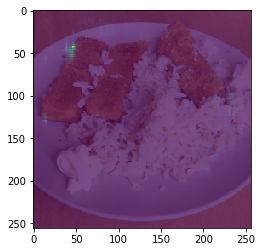

potatoes-steamed : 


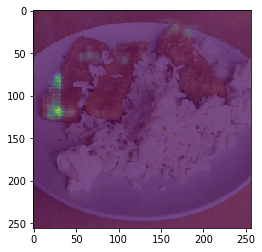

espresso-with-caffeine : 


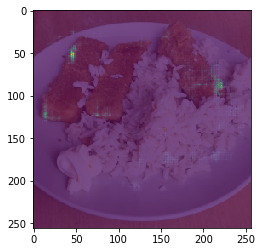

banana : 


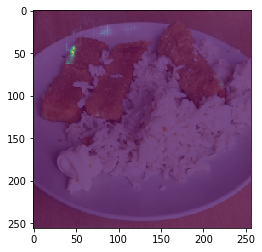

jam : 


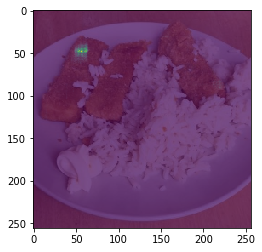

wine-red : 


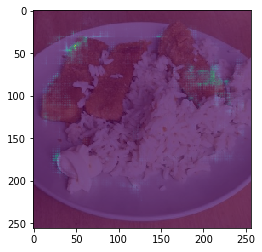

egg : 


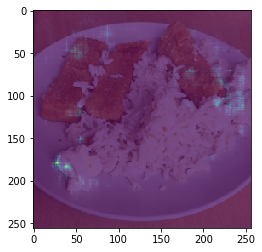

rice : 


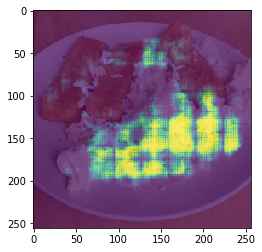

mixed-vegetables : 


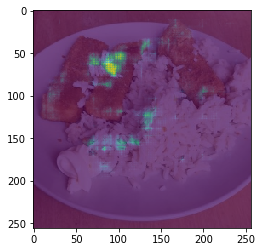

coffee-with-caffeine : 


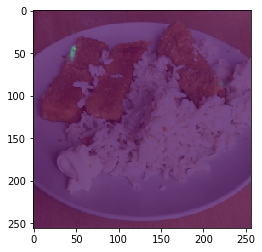

carrot : 


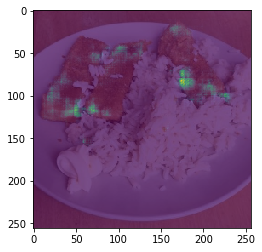

bread-wholemeal : 


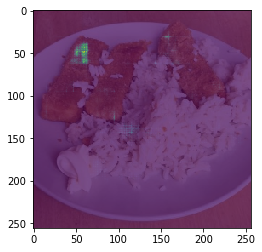

butter : 


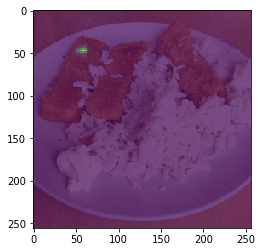

tomato : 


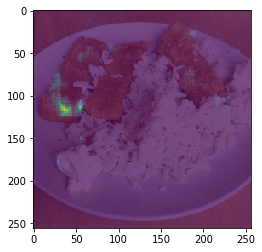

bread-white : 


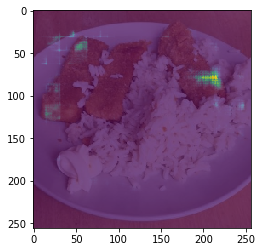

salad-leaf-salad-green : 


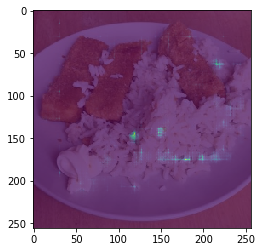

water : 


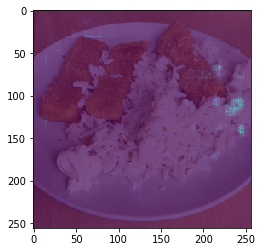

In [ ]:
plot_prediction(i = 30, show = True, category = 0, show_all_classes=True)

In [ ]:
#https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
#To convert to segmentation, calculate area and only keep ones over certain threshold